In [1]:
! pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

In [3]:
def convert_labels(example):
  example["label"] = [float(num) for num in example['label'][1:-1].split(' ')]
  example["prediction"] = [float(num) for num in example['prediction'][1:-1].split(' ')]
  return example

ds_url = f'/content/'
ds_files = {
    'train': ds_url + 'train_predictions.tsv',
    'validation': ds_url + 'validation_predictions.tsv',
}

ds = load_dataset('csv', data_files=ds_files, delimiter='\t')
ds = ds.rename_columns({'ID':'id', 'Prediction':'prediction', 'Label': 'label'})

ds = ds.map(convert_labels)

print(ds['train'].features)
print(ds['validation'].features)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'id': Value(dtype='int64', id=None), 'label': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'prediction': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}
{'id': Value(dtype='int64', id=None), 'label': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'prediction': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}


In [4]:
tags = ["Appeal to authority", "Appeal to fear/prejudice", "Bandwagon", "Black-and-white Fallacy/Dictatorship", "Causal Oversimplification", "Doubt", "Exaggeration/Minimisation", "Flag-waving", "Glittering generalities (Virtue)", "Loaded Language", " Misrepresentation of Someone's Position (Straw Man)", " Name calling/Labeling", " Obfuscation, Intentional vagueness, Confusion", " Presenting Irrelevant Data (Red Herring)", " Reductio ad hitlerum", " Repetition", " Slogans", " Smears", " Thought-terminating cliché", " Whataboutism"]
ix2tag = {i:tags[i] for i in range(len(tags))}
tag2ix = {tags[i]:i for i in range(len(tags))}

val_pred_counter = {tags[i]: 0 for i in range(len(tags))}
val_label_counter = {tags[i]: 0 for i in range(len(tags))}

for label in ds['validation']['prediction']:
  for i in range(len(label)):
    if label[i] == 1:
      val_pred_counter[tags[i]] += 1

for label in ds['validation']['label']:
  for i in range(len(label)):
    if label[i] == 1:
      val_label_counter[tags[i]] += 1

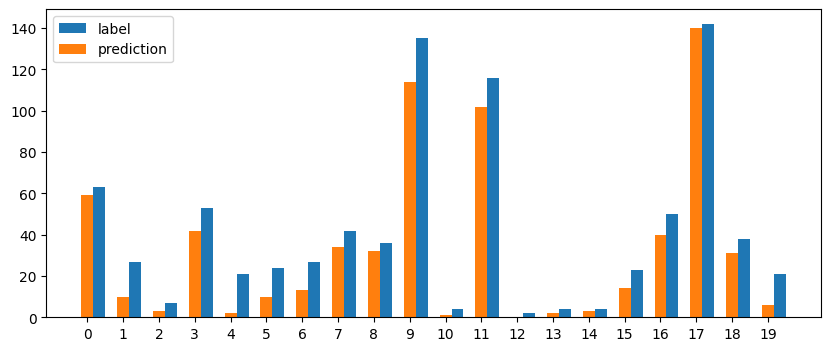

0 --> Appeal to authority
1 --> Appeal to fear/prejudice
2 --> Bandwagon
3 --> Black-and-white Fallacy/Dictatorship
4 --> Causal Oversimplification
5 --> Doubt
6 --> Exaggeration/Minimisation
7 --> Flag-waving
8 --> Glittering generalities (Virtue)
9 --> Loaded Language
10 -->  Misrepresentation of Someone's Position (Straw Man)
11 -->  Name calling/Labeling
12 -->  Obfuscation, Intentional vagueness, Confusion
13 -->  Presenting Irrelevant Data (Red Herring)
14 -->  Reductio ad hitlerum
15 -->  Repetition
16 -->  Slogans
17 -->  Smears
18 -->  Thought-terminating cliché
19 -->  Whataboutism


In [5]:
bar_labels = [str(i) for i in range(len(tags))]
val_pred_bar_values = [val_pred_counter[ix2tag[int(ix)]] for ix in bar_labels]
val_label_bar_values = [val_label_counter[ix2tag[int(ix)]] for ix in bar_labels]
figure(figsize=(10, 4))
plt.bar(3*np.arange(len(tags)) + 0.5, val_label_bar_values, tick_label=bar_labels, width=1, label='label')
# plt.title('Predictions')
# plt.show()
plt.bar(3*np.arange(len(tags)) - 0.5, val_pred_bar_values, tick_label=bar_labels, width=1, label='prediction')
plt.legend()
plt.show()
_ = [print(f'{i} --> {ix2tag[i]}') for i in range(len(ix2tag))]

In [7]:
val_label_no_tag = np.array(ds['validation']['label']).sum(axis=-1) == 0
val_pred_no_tag = np.array(ds['validation']['prediction']).sum(axis=-1) == 0
val_label_no_tag_n = (np.array(ds['validation']['label']).sum(axis=-1) == 0).sum()
val_pred_no_tag_n = (np.array(ds['validation']['prediction']).sum(axis=-1) == 0).sum()
print("Num of no tag memes in labels: ", val_label_no_tag_n)
print("Num of no tag memes in predictions: ", val_pred_no_tag_n )

Num of no tag memes in labels:  88
Num of no tag memes in predictions:  128


In [22]:
TP = ((val_label_no_tag == val_pred_no_tag) * val_label_no_tag).sum()
TN = ((val_label_no_tag == val_pred_no_tag) * (1 - val_label_no_tag)).sum()
FP = ((val_label_no_tag != val_pred_no_tag) * val_pred_no_tag).sum()
FN = ((val_label_no_tag != val_pred_no_tag) * (1 - val_pred_no_tag)).sum()

In [24]:
print(f"TP = {TP}\nTN = {TN}\nFP = {FP}\nFN = {FN}\nPositive: has no propaganda tag - Negetive: has at least one tag")

TP = 79
TN = 363
FP = 49
FN = 9
Positive: has no propaganda tag - Negetive: has at least one tag


In [29]:
mask = ((val_label_no_tag != val_pred_no_tag) * val_pred_no_tag)
np.array(ds['validation']['label'])[mask].sum(axis=-1)

array([2., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 1., 2., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 2., 1., 2.,
       1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1., 3., 1., 1., 1.])